# Get iCN718 datas and compare
This notebook presents iCN718 data in Reasoning / Filter / Guess & Check / Guess & Check Diversity.


To run correctly this notebook and have the same results as the paper, you must first download the raw results: [https://doi.org/10.57745/OS1JND](https://doi.org/10.57745/OS1JND)

This notebook is written with the hierarchy of downloaded files, if you want to try it with the test form the run notebooks, it is needed to first restructure your data to match the hierarchy of downloaded files.

We suppose here that the downloaded files are in a directory named "analyses", this directory path can be changed to your directory path where the data are saved.

> **WARNING**:
>
> On the paper the Venn diagramm was computed with  http://bioinformatics.psb.ugent.be/webtools/Venn/. Here we use a python implemantation of Venn diagramm to incorporate it into notebooks

## Requirements
Module *seaborn* and *venny4py* are needed

In [ ]:
!pip install seaborn

In [1]:
!pip install venny4py

# Variable to change (if wanted)

In [1]:
analyse_dir = "../../analyses"
metabolite_dir=f"{analyse_dir}/results/metabolites_iCN718"

# Initialisation and functions

In [3]:
import pandas as pd
from venny4py.venny4py import *
import seaborn as sns
import matplotlib.pyplot as plt

In [13]:
metabolites_file = f"{metabolite_dir}/metabolites_occurences.tsv"
file_exch = f"{metabolite_dir}/iCN718_exchanges.txt"

iCN718_1000_reas_dir = os.path.join(analyse_dir, "results", "s2lp_reasoning", "iCN718")
iCN718_1000_hyb_cobra_dir = os.path.join(analyse_dir, "results", "s2lp_hyb_cobra", "iCN718")


iCN718_2000_dir = os.path.join(analyse_dir, "results", "iCN718_2000", "iCN718")

In [8]:
def get_metabolites(file):
    metabolites=pd.read_csv(file,sep='\t')
    metabolites.rename( columns={'Unnamed: 0':'metabolites'}, inplace=True )
    for index, met in metabolites.iterrows():
        name=met["metabolites"].removeprefix("M_").strip().removesuffix("_e").removesuffix("_c")
        metabolites.loc[index, 'metabolites']=name
    metabolites=metabolites.groupby(['metabolites']).sum()

    return metabolites.reset_index()

In [9]:
def get_fluxes(directory:str, mode:str, optim:str=None):
    flux_all=pd.DataFrame(columns=['species', 'biomass_reaction', 'solver_type', 'search_mode',
                                     'search_type', 'accumulation', 'model', 'size', 'lp_flux', 'cobra_flux_init',
                                     'cobra_flux_no_import', 'cobra_flux_seeds', 'cobra_flux_demands',
                                     'has_flux', 'has_flux_seeds', 'has_flux_demands', 'timer'])
    flux_all['accumulation'] = flux_all['accumulation'].astype('bool')
    flux_all['has_flux'] = flux_all['has_flux'].astype('bool')
    flux_all['has_flux_seeds'] = flux_all['has_flux_seeds'].astype('bool')
    flux_all['has_flux_demands'] = flux_all['has_flux_demands'].astype('bool')

    for filename in os.listdir(directory):
        if "_fluxes.tsv" in filename or "_fluxes_from_result.tsv" in filename:
            # By default in this notebook we want the no accumulation mode for seed2lp results
            if  "_no_accu_" in filename \
                and   ((mode == "full" and "_fn_" in filename) \
                    or (mode == "target" and "_tgt_" in filename))\
                or mode == "netseed":
                file_path=os.path.join(directory, filename)
                current_df = pd.read_csv(file_path, sep='\t', lineterminator='\n')
                current_df['accumulation'] = current_df['accumulation'].astype('bool')
                current_df['has_flux'] = current_df['has_flux'].astype('bool')
                current_df['has_flux_seeds'] = current_df['has_flux_seeds'].astype('bool')
                current_df['has_flux_demands'] = current_df['has_flux_demands'].astype('bool')
                flux_all=pd.concat([flux_all if not flux_all.empty else None, current_df], ignore_index=True)
    flux_all = flux_all[flux_all["model"]!="model_one_solution"]
    flux_all = flux_all[flux_all["model"]!="model_one_solution"]
    if optim=="submin":
        return flux_all[flux_all["search_mode"]=="Subset Minimal"]
    elif optim=="min":
        return flux_all[flux_all["search_mode"]=="Minimize"]
    else:
        return flux_all

In [10]:
def get_data_1000(table_reasoning, table_hybrid):
    table_hybrid["solver_type"] = table_hybrid["solver_type"].str.replace('REASONING  GUESS-CHECK-DIVERSITY', 'REASONING GUESS-CHECK DIVERSITY')
    table_hybrid["solver_type"] = table_hybrid["solver_type"].str.replace('REASONING  GUESS-CHECK', 'REASONING GUESS-CHECK')
    table_hybrid["solver_type"] = table_hybrid["solver_type"].str.replace('REASONING  FILTER', 'REASONING FILTER')

    # CLASSIC
    table_reasoning = table_reasoning[table_reasoning["solver_type"]=="REASONING"]
    nb_true = table_reasoning['has_flux'].sum()
    
    # FILTER
    table_filter = table_hybrid[table_hybrid["solver_type"]=="REASONING FILTER"]

    # GUESS_CHECK
    table_gc = table_hybrid[table_hybrid["solver_type"]=="REASONING GUESS-CHECK"]

    # GUESS_CHECK_DIV
    table_gcd = table_hybrid[table_hybrid["solver_type"]=="REASONING GUESS-CHECK DIVERSITY"]

    print(f"Total number of network\nReasoning: {len(table_reasoning)}\t\tFilter: {len(table_filter)}\t Guess-Check: {len(table_gc)}\t Guess-Check Div: {len(table_gcd)}")
    print(f"All FBA validation\nReasoning: {nb_true} / {len(table_reasoning)} networks")

In [14]:
def get_data_2000(table):
    table["solver_type"] = table["solver_type"].str.replace('REASONING  GUESS-CHECK-DIVERSITY', 'REASONING GUESS-CHECK DIVERSITY')
    table["solver_type"] = table["solver_type"].str.replace('REASONING  GUESS-CHECK', 'REASONING GUESS-CHECK')
    table["solver_type"] = table["solver_type"].str.replace('REASONING  FILTER', 'REASONING FILTER')

    # CLASSIC
    table_reasoning = table[table["solver_type"]=="REASONING"]
    nb_true = table_reasoning['has_flux'].sum()
    
    # FILTER
    table_filter = table[table["solver_type"]=="REASONING FILTER"]

    # GUESS_CHECK
    table_gc = table[table["solver_type"]=="REASONING GUESS-CHECK"]

    # GUESS_CHECK_DIV
    table_gcd = table[table["solver_type"]=="REASONING GUESS-CHECK DIVERSITY"]

    print(f"Total number of network\nReasoning: {len(table_reasoning)}\t\tFilter: {len(table_filter)}\t Guess-Check: {len(table_gc)}\t Guess-Check Div: {len(table_gcd)}")
    print(f"All FBA validation\nReasoning: {nb_true} / {len(table_reasoning)} networks")

In [11]:
def plot_venn(metabolites):
    reasoning = metabolites[metabolites["nb_reasoning"]>0]
    filter = metabolites[metabolites["nb_filter"]>0]
    gc = metabolites[metabolites["nb_gc"]>0]
    gcd = metabolites[metabolites["nb_gcd"]>0]

    sets = {
    'Reasoning': set(reasoning["metabolites"]),
    'Filter': set(filter["metabolites"]),
    'Guess&Check': set(gc["metabolites"]),
    'Guess&Check Diversity': set(gcd["metabolites"])}
    
    venny4py(sets=sets)

In [12]:
def plot_metabolites(metabolites:pd.DataFrame, mode, nb:int=0):

    with open(file_exch, 'r') as file:
        exch_list = file.read().split()

    match mode:
        case "reasoning":
            col="nb_reasoning"
        case "filter":
            col="nb_filter"
        case "gc":
            col="nb_gc"
        case "gcd":
            col="nb_gcd"
            
    metabolites["colors"]="internal"
    for index, line in metabolites.iterrows():
        if line[col] == 0:
            metabolites=metabolites.drop(index)
        elif line["metabolites"] in exch_list:
            metabolites.loc[index, 'colors']="exchange"
            

    metabolites_mode=pd.DataFrame()
    metabolites_mode=metabolites[["metabolites",col,"colors"]]
    metabolites_mode=metabolites_mode.sort_values(by=[col], ascending=False)
    if nb!=0:
        metabolites_mode=metabolites_mode.head(nb)
    labels=metabolites_mode["metabolites"].to_list()

    size=len(labels)
    count=metabolites_mode['colors'].value_counts()

    print ("exchange: ", count["exchange"], "/ total: " , size)

    if nb==0:
        x_limit = size*0.7
        y_limit = 20
        size="full"
    else:
        x_limit = size*0.4
        y_limit = 2
    fig_size = (x_limit,y_limit)

    plt.figure(figsize=(fig_size))
    fig=sns.barplot(data=metabolites_mode, x='metabolites', y=col, hue="colors",palette=["#003380ff","#dd8452ff"],hue_order=["internal","exchange"])
    fig.set_ylim(0, 2000)
    if nb == 0:
        plt.ylabel('Occurences',fontsize=30)
        plt.xlabel('Metabolites',fontsize=30)
        plt.xticks(labels,rotation=45, horizontalalignment='right', fontsize=30 )
        plt.yticks(fontsize=30)
    else:
        plt.ylabel('Occurences')
        plt.xlabel('Metabolites')
        plt.xticks(labels,rotation=45, horizontalalignment='right' ) 
    sns.despine(bottom=True)
    plt.tick_params(bottom=False, left=True)
    plt.legend(frameon=False, bbox_to_anchor=(1, 1), loc='upper right', borderaxespad=-10)


# Get data

In [11]:
metabolites = get_metabolites(metabolites_file)

In [12]:
iCN_1000_reas = get_fluxes(iCN718_1000_reas_dir, "target", "submin")

In [13]:
iCN_1000_hyb = get_fluxes(iCN718_1000_hyb_cobra_dir, "target", "submin")

In [21]:
get_data_1000(iCN_1000_reas, iCN_1000_hyb)

Total number of network
Reasoning: 1000		Filter: 149	 Guess-Check: 116	 Guess-Check Div: 111
All FBA validation
Reasoning: 465 / 1000 networks


In [15]:
iCN_2000 = get_fluxes(iCN718_2000_dir, "target", "submin")

In [18]:
get_data_2000(iCN_2000)

Total number of network
Reasoning: 2000		Filter: 2000	 Guess-Check: 2000	 Guess-Check Div: 2000
All FBA validation
Reasoning: 381 / 2000 networks


# PLOT

## Venn Diagramm

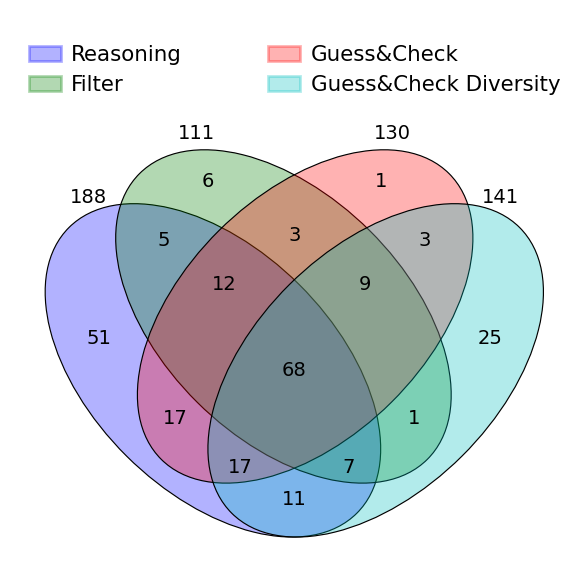

In [22]:
plot_venn(metabolites)

## Metabolite occurences in solutions

exchange:  1 / total:  10


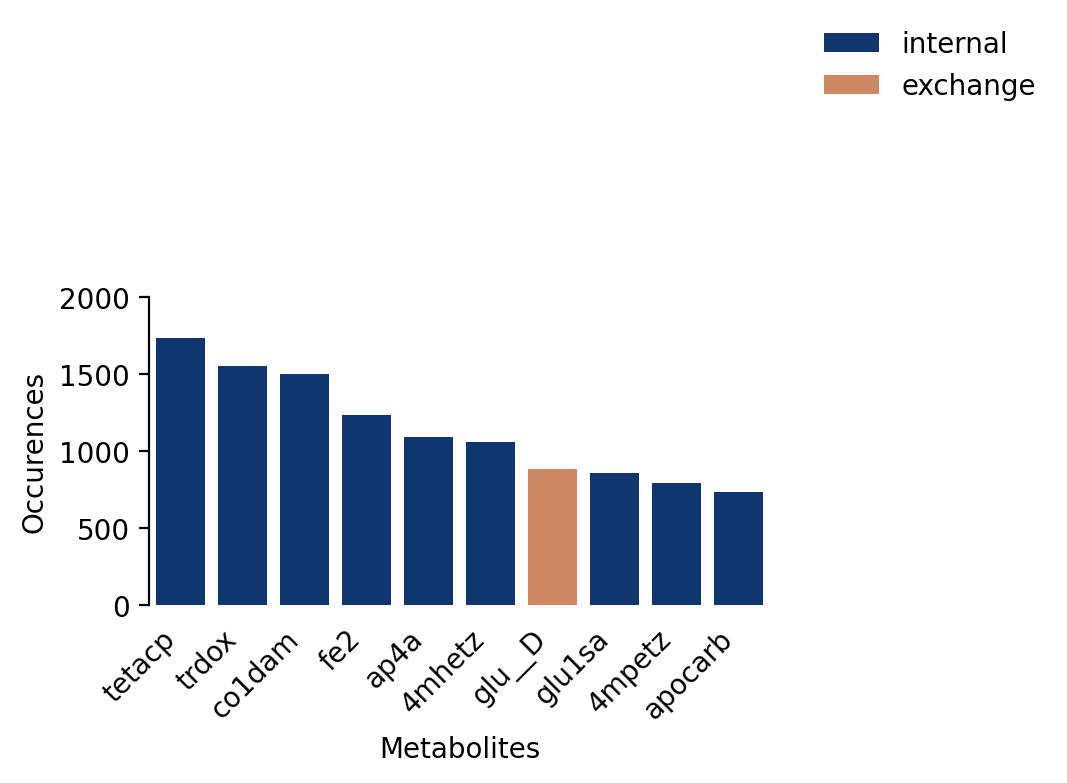

In [23]:
plot_metabolites(metabolites,"reasoning",10)

exchange:  4 / total:  10


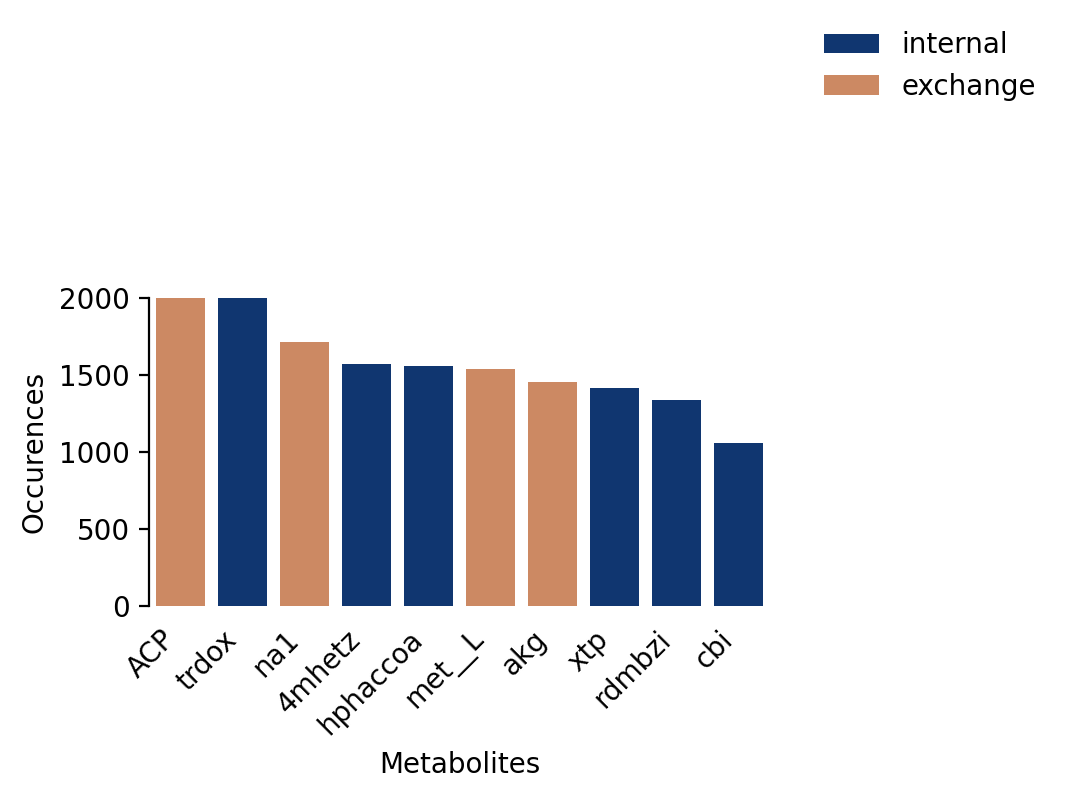

In [24]:
plot_metabolites(metabolites,"filter",10)

exchange:  4 / total:  10


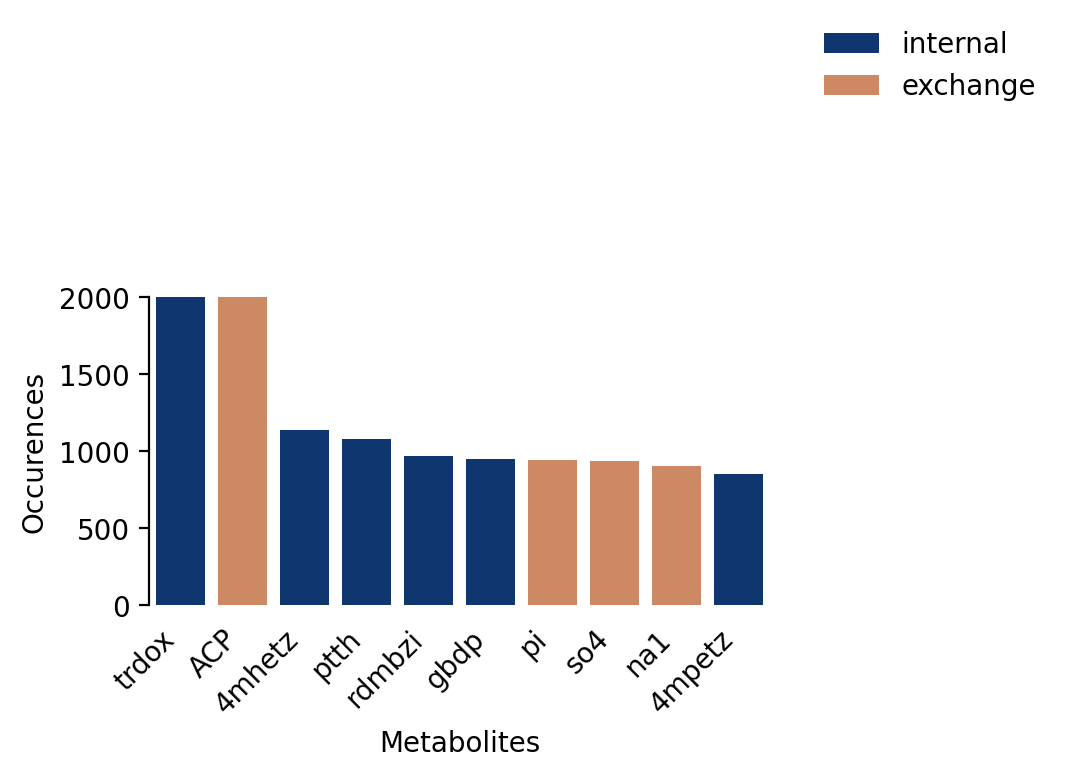

In [25]:
plot_metabolites(metabolites,"gc",10)

exchange:  3 / total:  10


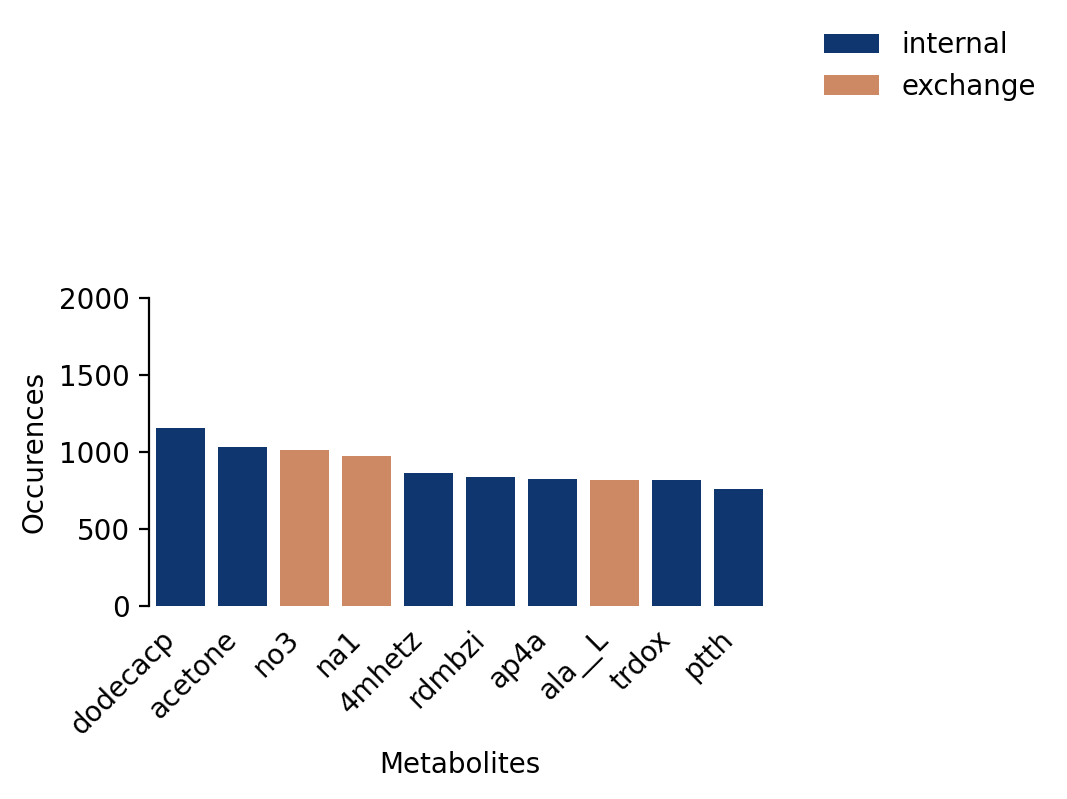

In [26]:
plot_metabolites(metabolites,"gcd",10)